In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define the path where our dataset is stored
dataset_path = 'archive/TrashType_Image_Dataset'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

cardboard folder contains 403 images.
glass folder contains 501 images.
metal folder contains 410 images.
paper folder contains 594 images.
plastic folder contains 482 images.
trash folder contains 137 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


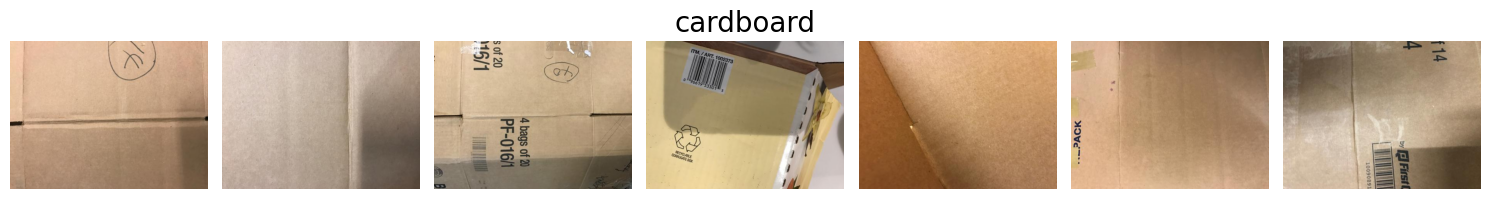

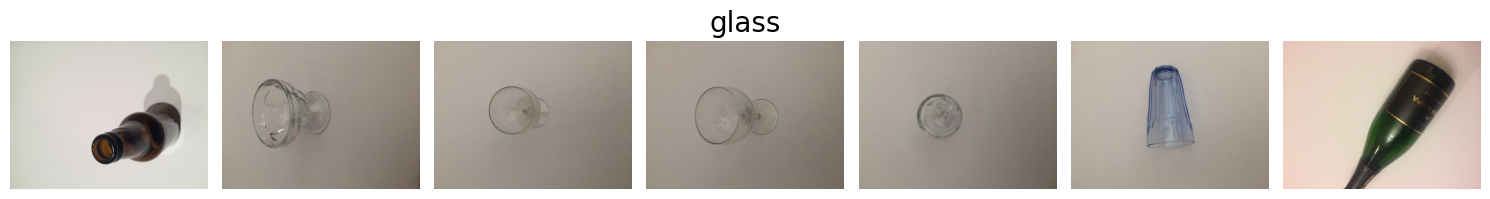

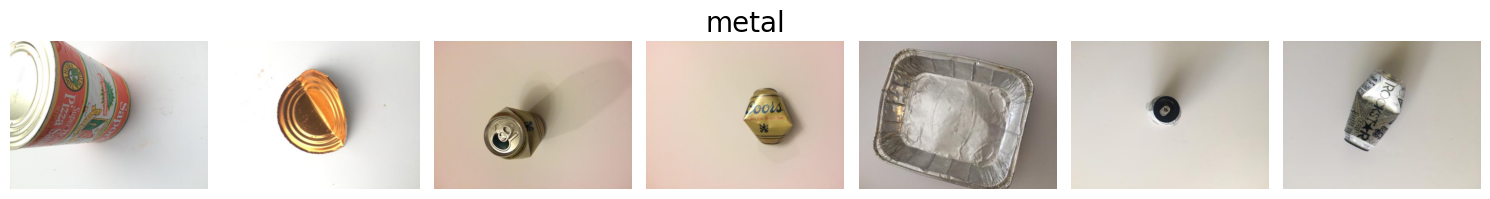

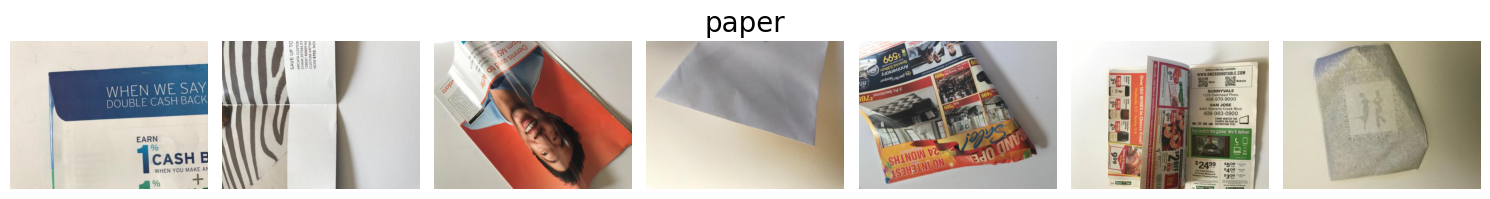

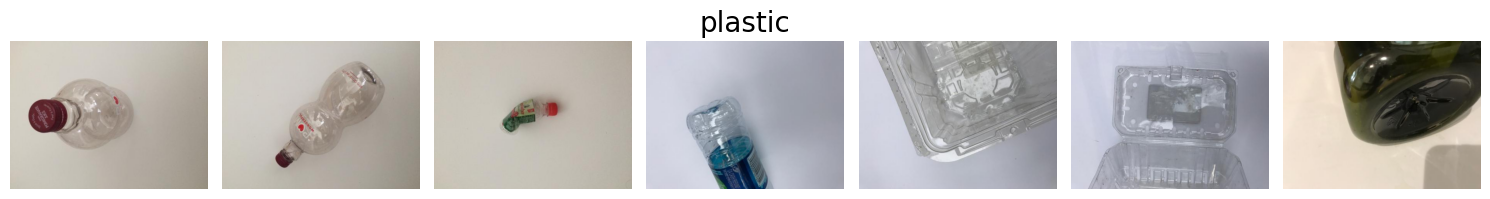

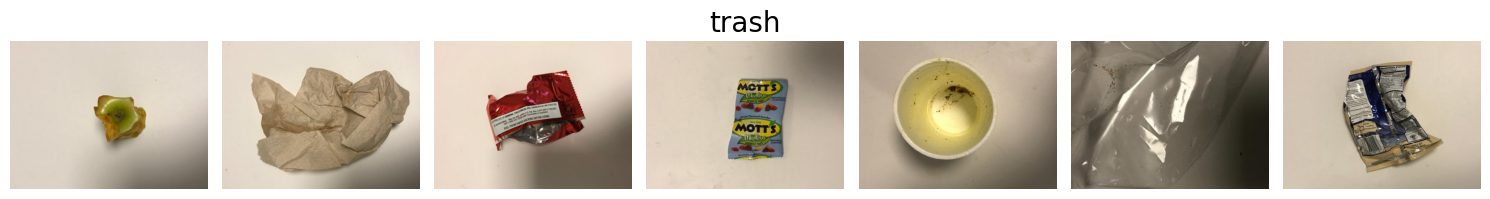

In [3]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Select the first 10 images
        image_files = image_files[:7]
        
        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [4]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,archive/TrashType_Image_Dataset\cardboard\card...,cardboard
1,archive/TrashType_Image_Dataset\cardboard\card...,cardboard
2,archive/TrashType_Image_Dataset\cardboard\card...,cardboard
3,archive/TrashType_Image_Dataset\cardboard\card...,cardboard
4,archive/TrashType_Image_Dataset\cardboard\card...,cardboard


In [5]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


In [6]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [7]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [9]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [10]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [11]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [12]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [13]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [14]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implement a residual block for ResNet architectures.
    
    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    kernel_size -- integer, kernel size of the middle convolutional layer in the main path
    filters     -- python list of integers, defining the number of filters in the CONV layers of the main path
    reduce      -- boolean, whether to reduce the spatial dimensions and increase depth; 
                    if True, applies 1x1 CONV layer to the shortcut path.
    stride      -- integer, strides for the convolutional layer
    
    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. We will need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [15]:
def ResNet_50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3 
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4 
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5 
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)
    
    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)
        
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [16]:
def Modified_ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Stage 3 
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Stage 4 
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5 
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)
    
    # Add Dropout to prevent overfitting
    X = Dropout(0.5)(X)
    
    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)
        
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='Modified_ResNet50')

    return model

In [17]:
# Define the shape of the input images and number of classes
input_shape = (384, 384, 3)
num_classes = 6

# Initialize the modified ResNet50 model with the specified parameters
modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, classes=num_classes)

In [18]:
plot_model(modified_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [19]:
modified_resnet50_model.summary()

Model: "Modified_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 189, 189,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 189, 189,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 189, 189,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 94, 94,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 94, 94,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 94, 94,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 94, 94,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 94, 94,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 94, 94,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 94, 94,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 94, 94,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 94, 94,    │          0 │ add[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
modified_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True, verbose=1)

In [22]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [23]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [24]:
# Total number of epochs
num_epochs = 1 

# Train the model
history = modified_resnet50_model.fit(train_generator, 
                                      steps_per_epoch=len(train_generator), 
                                      epochs=num_epochs, 
                                      validation_data=val_generator, 
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

64/64 ━━━━━━━━━━━━━━━━━━━━ 918s 14s/step - accuracy: 0.3271 - loss: 2.6174 - val_accuracy: 0.1680 - val_loss: 767.6725 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [25]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

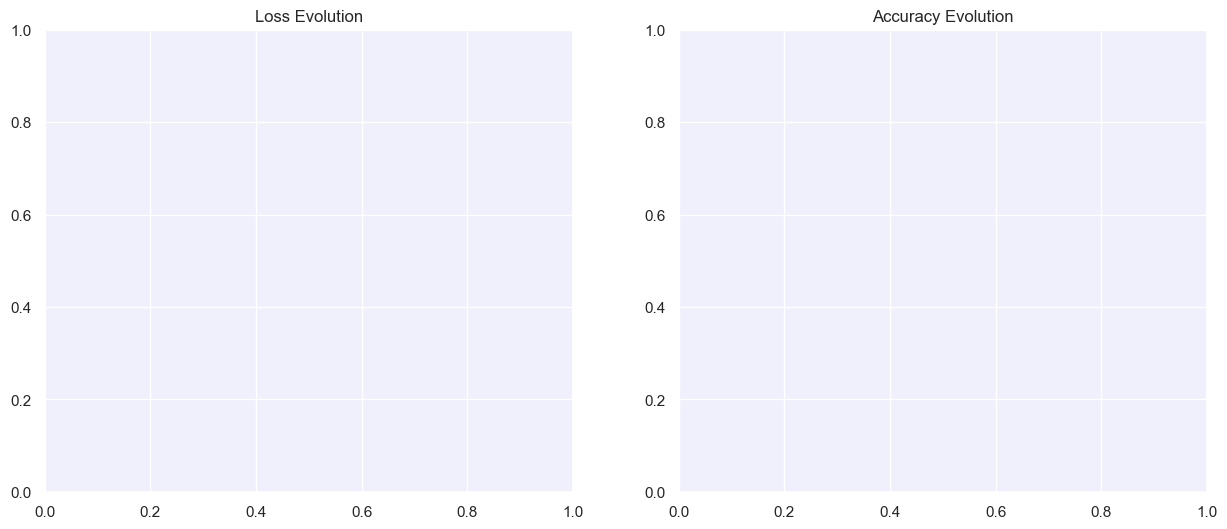

In [26]:
plot_learning_curves(history)

In [27]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
              precision    recall  f1-score   support

   cardboard       0.16      1.00      0.28        81
       glass       0.00      0.00      0.00       100
       metal       0.00      0.00      0.00        82
       paper       0.27      0.03      0.06       119
     plastic       0.00      0.00      0.00        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.17       506
   macro avg       0.07      0.17      0.06       506
weighted avg       0.09      0.17      0.06       506





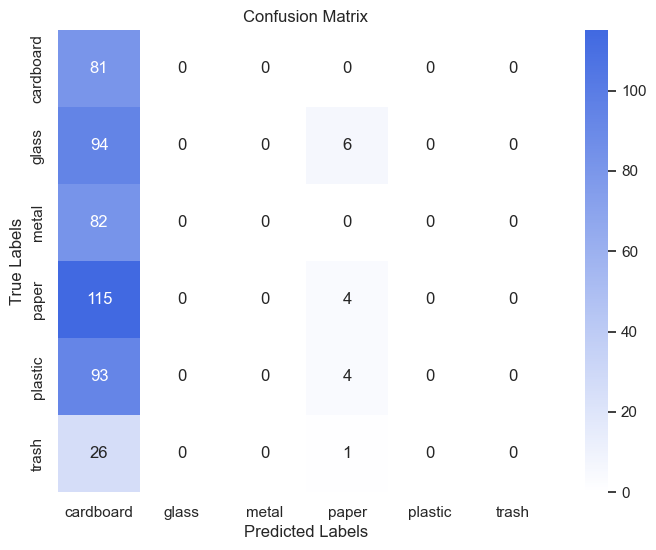

In [28]:
evaluate_model_performance(modified_resnet50_model, val_generator, class_labels)

In [29]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

In [30]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [31]:
len(base_model.layers) 

175

In [32]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [33]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [34]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
plot_model(transfer_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [36]:
transfer_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 14,988,294 (57.18 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [37]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

In [38]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [39]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 1

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator), 
                                      epochs=num_epochs,
                                      validation_data=val_generator, 
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

64/64 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.5102 - loss: 1.3694 - val_accuracy: 0.7569 - val_loss: 0.7672 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


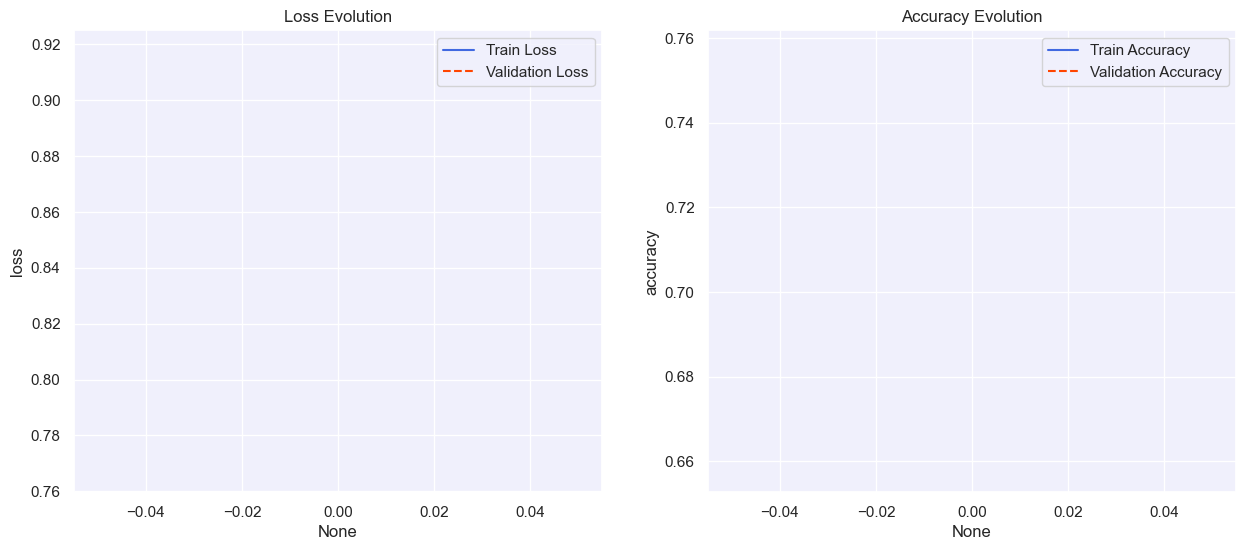

In [40]:
plot_learning_curves(history, start_epoch=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
              precision    recall  f1-score   support

   cardboard       0.98      0.68      0.80        81
       glass       0.62      0.98      0.76       100
       metal       1.00      0.39      0.56        82
       paper       0.72      0.97      0.83       119
     plastic       0.91      0.71      0.80        97
       trash       0.59      0.48      0.53        27

    accuracy                           0.76       506
   macro avg       0.80      0.70      0.71       506
weighted avg       0.82      0.76      0.75       506





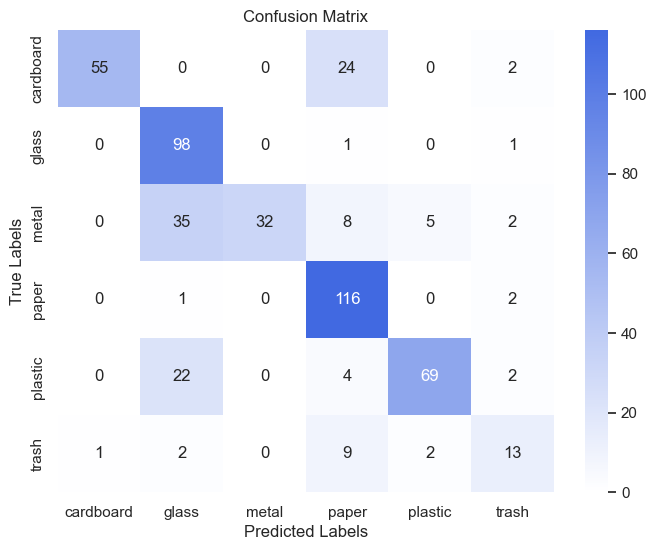

In [41]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

In [42]:
MODEL_FILENAME = 'transfer_resnet50_trash_classifier.h5'

print(f"Saving the final trained model to {MODEL_FILENAME}...")
# Save the entire model (architecture, weights, optimizer state, etc.)
transfer_resnet50_model.save(MODEL_FILENAME)
print("Model saved successfully for future prediction.")

# --------------------------------------------------------------------------------
# 2. Model Loading and Evaluation
# --------------------------------------------------------------------------------

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Load the Model for Prediction
print("\nLoading the saved model for prediction demonstration...")
# You must have 'from tensorflow.keras.models import load_model' imported
loaded_model = load_model(MODEL_FILENAME)

# Evaluation on Validation Set
print("\n--- Model Evaluation on Validation Set ---")
# Reset generator to ensure predictions start from the beginning
val_generator.reset()
loss, accuracy = loaded_model.evaluate(
    val_generator, 
    steps=len(val_generator), 
    verbose=1
)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Detailed Prediction Report
print("\n--- Detailed Classification Report ---")
val_generator.reset()

# Get predicted probabilities
predictions = loaded_model.predict(val_generator, steps=len(val_generator))

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels and class names
true_classes = val_generator.classes
class_indices = val_generator.class_indices
inverted_class_indices = dict((v, k) for k, v in class_indices.items())
# Ensure labels are sorted by index (0, 1, 2, ...) to match the report's structure
sorted_class_labels = [inverted_class_indices[i] for i in range(len(inverted_class_indices))]

# Generate report
print(classification_report(true_classes, predicted_classes, target_names=sorted_class_labels))


# --------------------------------------------------------------------------------
# 3. Single Image Prediction Function
# --------------------------------------------------------------------------------

def predict_single_image(model, image_path, target_size=(384, 384)):
    """Predicts the class of a single image file."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img, dtype=np.float32)
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, 0.0
        
    # Apply the same preprocessing as the training (ResNet50 preprocess_input)
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    
    prediction = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(prediction)
    
    # Get the label name from the inverted class index map
    class_indices = val_generator.class_indices
    inverted_class_indices = dict((v, k) for k, v in class_indices.items())
    sorted_class_labels = [inverted_class_indices[i] for i in range(len(inverted_class_indices))]

    predicted_label = sorted_class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    
    return predicted_label, confidence

print("\n--- Single Prediction Example ---")
try:
    # Use the first image path from the validation DataFrame for a demonstration
    sample_image_row = val_df.iloc[0]
    sample_image_path = sample_image_row['filepath']
    
    label, confidence = predict_single_image(loaded_model, sample_image_path)
    if label:
        print(f"Sample Image Path: {sample_image_path}")
        print(f"Predicted Class: {label} (Confidence: {confidence:.2f})")
except NameError:
    print("Note: Single image prediction code relies on 'val_df' being defined from a previous cell.")
except Exception as e:
    print(f"An error occurred during single image prediction: {e}")

Saving the final trained model to transfer_resnet50_trash_classifier.h5...
Model saved successfully for future prediction.

Loading the saved model for prediction demonstration...



--- Model Evaluation on Validation Set ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7607 - loss: 0.7474

Validation Loss: 0.7672
Validation Accuracy: 0.7569

--- Detailed Classification Report ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step
              precision    recall  f1-score   support

   cardboard       0.98      0.68      0.80        81
       glass       0.62      0.98      0.76       100
       metal       1.00      0.39      0.56        82
       paper       0.72      0.97      0.83       119
     plastic       0.91      0.71      0.80        97
       trash       0.59      0.48      0.53        27

    accuracy                           0.76       506
   macro avg       0.80      0.70      0.71       506
weighted avg       0.82      0.76      0.75       506


--- Single Prediction Example ---
Sample Image Path: archive/TrashType_Image_Dataset\plastic\plastic_119.jpg
Predicted Class: glass (Confidence: 0.56)


In [2]:
import numpy as np
from PIL import Image
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# --- CONFIGURATION (Ensure this matches your training) ---
MODEL_FILENAME = 'transfer_resnet50_trash_classifier.h5'
TARGET_SIZE = (384, 384) 

# Replace this with the path to the image you want to test
# Example structure based on your code:
TEST_IMAGE_PATH = 'archive/TrashType_Image_Dataset/paper/paper_021.jpg' 

# --- PLACEHOLDER FOR CLASS LABELS ---
# Since this code is standalone, it needs to manually define the class mapping
# that was originally contained in val_generator.
# Assuming the 6 classes based on your initial code:
# This dictionary must match the order the model was trained on (0=cardboard, 1=glass, etc.)
CLASS_LABELS_MAP = {
    0: 'cardboard', 
    1: 'glass', 
    2: 'metal', 
    3: 'paper', 
    4: 'plastic', 
    5: 'trash'
}
sorted_class_labels = [CLASS_LABELS_MAP[i] for i in sorted(CLASS_LABELS_MAP.keys())]

# --- 1. Load the Model ---
try:
    # We use 'compile=False' to skip the compilation step if the custom layers/optimizer 
    # were not saved correctly, focusing only on prediction.
    loaded_model = load_model(MODEL_FILENAME, compile=False) 
    print(f"Model loaded successfully from: {MODEL_FILENAME}")
except Exception as e:
    print(f"Error loading model: {e}")
    # If the model fails to load, the rest of the script cannot proceed.
    exit()
    
# --- 2. Single Image Prediction Function ---
def predict_single_image(model, image_path, class_labels, target_size=TARGET_SIZE):
    """Predicts the class of a single image file."""
    
    # 2.1 Load and Preprocess Image
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img, dtype=np.float32)
    except FileNotFoundError:
        return f"Error: Image file not found at {image_path}", 0.0
    except Exception as e:
        return f"Error loading or resizing image: {e}", 0.0
        
    # Apply the same preprocessing used during training (ResNet50 preprocess_input)
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    
    # 2.2 Make Prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(prediction)
    
    # 2.3 Get Label and Confidence
    predicted_label = class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return predicted_label, confidence

# --- 3. Run Prediction ---
print("\n--- Running Single Image Prediction ---")

predicted_label, confidence = predict_single_image(loaded_model, TEST_IMAGE_PATH, sorted_class_labels)

print(f"\nTested Image Path: {TEST_IMAGE_PATH}")
print(f"Predicted Class: {predicted_label}")
print(f"Confidence Score: {confidence:.4f}")

Model loaded successfully from: transfer_resnet50_trash_classifier.h5

--- Running Single Image Prediction ---

Tested Image Path: archive/TrashType_Image_Dataset/paper/paper_021.jpg
Predicted Class: paper
Confidence Score: 0.9969
